<a href="https://colab.research.google.com/github/isikaykarakus/BookStore/blob/main/Semantic_segmentation_using_SegNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'semantic-segmentation-of-aerial-imagery:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F681625%2F1196732%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240525%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240525T175943Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2c2772755e80dd192852cb267f2b434dca065404db33f5732f37e84ead717c8b027e8d2928aa455c015c1a525ad519794189ad7eb6b2d3c51b84a7eec415b9de2b1b9db8531260d7d8dc6605b20b47aae321c163daa9e011743db608e36da830ff34b6a78b2bf275fd86a3281ed2540bffe1d40d649e1e2644a4aae3539b8b23c9e35f4bcc24cf1db084f54ff005db5fc27710999d5614660cce39d31858c948dc528a004fe9e0be78fd66a0442ca67831a2d9750379f83851ae6aee278007b1e6e9c5242f263d527f409f7aa451cd4689eaeaca88f2741783e068c4c302dc0f786a3f19e9448437200eb09ee4ea0acad771260af0ad89d709e5e5b3f37b5592'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 31045284 bytes downloaded
Downloaded and uncompressed: semantic-segmentation-of-aerial-imagery
Data source import complete.


# Load Dependencies


In [110]:
!pip install patchify

In [111]:

from patchify import patchify
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from torch.utils.data import Dataset
import torch
import torch.nn as nn
from tqdm import tqdm
import torchvision.models as models
from IPython.display import clear_output
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.math import log , reduce_mean
from tensorflow.keras.utils import to_categorical
import torch
import torch.nn as nn
import torch
from tqdm import tqdm


# Importing & Patching Data 💾


In [112]:
def create_dir(dir_name):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name, exist_ok=True)

In [113]:
root_directory = "/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/"
patch_size = 256
scaler = MinMaxScaler()

In [114]:
image_dataset = []
for path,subdirs,files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':
        images = os.listdir(path)
        images.sort()
        for i, image_name in enumerate(images):
            if image_name.endswith(".jpg"):
                image = cv2.imread(path+"/"+image_name,1)
                SIZE_X = (image.shape[1]//patch_size)*patch_size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size
                image = Image.fromarray(image)
                image = image.crop((0,0,SIZE_X,SIZE_Y))
                image = np.array(image)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)

                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        single_patch_img = patches_img[i,j,0,:,:]
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        image_dataset.append(single_patch_img)

In [115]:
mask_dataset = []
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':
        masks = os.listdir(path)
        masks.sort()
        for i, mask_name in enumerate(masks):
            if mask_name.endswith(".png"):

                mask = cv2.imread(path+'/'+mask_name, 1)
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size
                mask = Image.fromarray(mask)
                mask = mask.crop((0,0,SIZE_X,SIZE_Y))
                mask = np.array(mask)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)

                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        single_patch_mask = patches_mask[i,j,0,:,:]
                        mask_dataset.append(single_patch_mask)

In [116]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)
image_dataset.shape

(1305, 256, 256, 3)

## Visualize images and masks

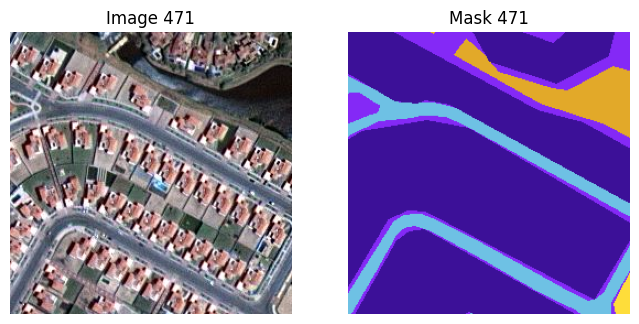

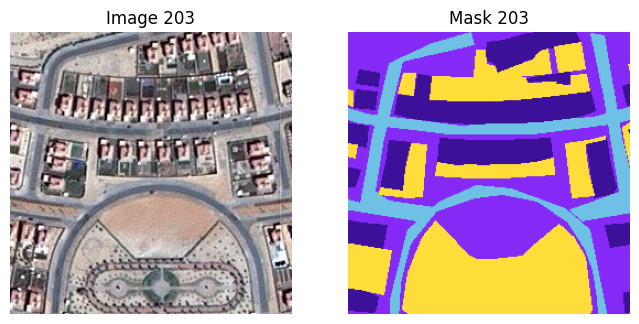

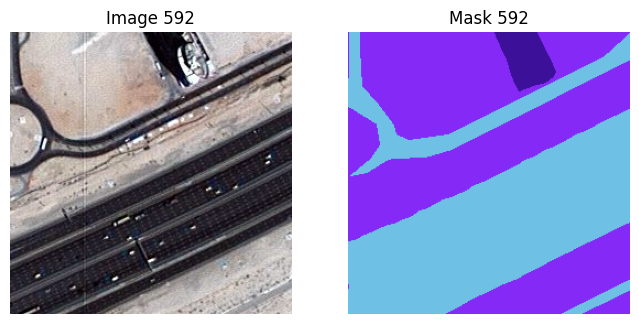

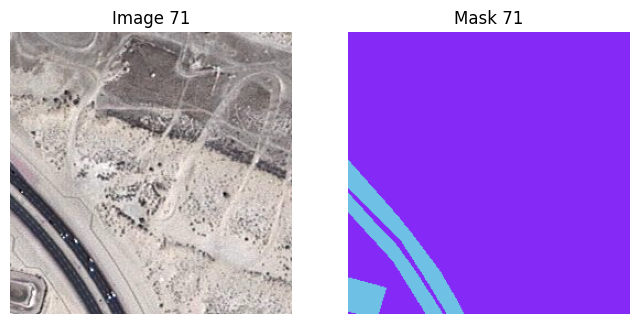

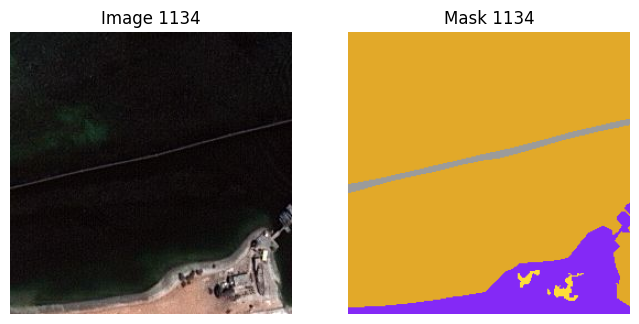

In [117]:
num_pairs = 5  # Set the number of pairs you want to display
patch_size = 256  # Ensure you have defined patch_size correctly

# Assuming 'image_dataset' and 'mask_dataset' are defined and are numpy arrays
for _ in range(num_pairs):
    image_number = random.randint(0, len(image_dataset) - 1)  # Select a random index
    plt.figure(figsize=(8, 4))  # Smaller figure size

    # Display the image
    plt.subplot(121)
    plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
    plt.title(f'Image {image_number}')  # Optional: add title to the image
    plt.axis('off')  # Hide the axis

    # Display the corresponding mask
    plt.subplot(122)
    plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
    plt.title(f'Mask {image_number}')  # Optional: add title to the mask
    plt.axis('off')  # Hide the axis

    plt.show()

## Convert  Mask Color

<b>Masks Conversion:</b> Mask images, which are initially in RGB format with specific colors representing different classes, are converted to a categorical format using a custom function rgb_to_2D_label. Each color is mapped to a specific class label (e.g., building, road, vegetation), and then converted into a one-hot encoded format suitable for classification.

In [118]:
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#')
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#')
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#')
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155



In [119]:
"""label = single_patch_mask

def rgb_to_2D_label(label):
    label_seg = np.zeros(label.shape, dtype=np.uint8)
    label_seg [np.all(label == Unlabeled, axis = -1)] = 0
    label_seg [np.all(label == Land, axis = -1)] = 1
    label_seg [np.all(label == Road, axis = -1)] = 2
    label_seg [np.all(label == Vegetation, axis = -1)] = 3
    label_seg [np.all(label == Water, axis = -1)] = 4
    label_seg [np.all(label == Building, axis = -1)] = 5

    label_seg = label_seg[:,:,0]

    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)


labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

print("Unique labels in label dataset are: ", np.unique(labels))"""


'label = single_patch_mask\n\ndef rgb_to_2D_label(label):\n    label_seg = np.zeros(label.shape, dtype=np.uint8)\n    label_seg [np.all(label == Unlabeled, axis = -1)] = 0\n    label_seg [np.all(label == Land, axis = -1)] = 1\n    label_seg [np.all(label == Road, axis = -1)] = 2  \n    label_seg [np.all(label == Vegetation, axis = -1)] = 3   \n    label_seg [np.all(label == Water, axis = -1)] = 4\n    label_seg [np.all(label == Building, axis = -1)] = 5\n    \n    label_seg = label_seg[:,:,0]\n    \n    return label_seg\n\nlabels = []\nfor i in range(mask_dataset.shape[0]):\n    label = rgb_to_2D_label(mask_dataset[i])\n    labels.append(label)\n\n    \nlabels = np.array(labels)   \nlabels = np.expand_dims(labels, axis=3)\n \nprint("Unique labels in label dataset are: ", np.unique(labels))'

In [120]:

def rgb_to_2D_label(label,num_class=6):
    """
    Suply our labale masks as input in RGB format.
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5

    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels


    new_label = np.zeros(label_seg.shape + (num_class,))


    for i in range(num_class):
        new_label[label_seg == i,i] = 1
    label_seg=new_label

    return label_seg

In [121]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)


labels = np.array(labels)

# labels=np.expand_dims(labels,axis=3)

print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0. 1.]


In [122]:
image_dataset[0].shape,labels.shape
print(len(images))

9


In [123]:
labels = np.array(labels)
labels_cat = to_categorical(labels)
labels_cat.shape

(1305, 256, 256, 6, 2)

Double check

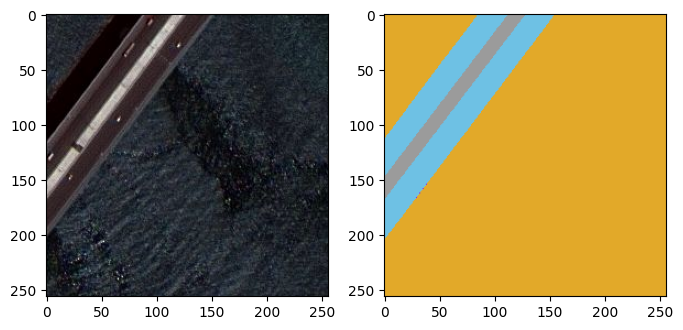

In [124]:
image_number = random.randint(0,len(image_dataset))
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

# DataLoaders & Augmentation🔧



Custom Dataset Class (Aerial): A custom Dataset class is defined for loading images and masks, which allows integration with PyTorch's DataLoader to efficiently handle batching, shuffling, and other data handling operations during training. Train-Validation Split: The dataset is split into training and validation sets to evaluate the model's performance on unseen data.

In [125]:
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
class Aerial(Dataset):
    def __init__(self,images,maskes):
        super(Aerial,self).__init__()
        self.images = images
        self.masks = maskes
        self.n_samples =len(images)


    def __getitem__(self,index):
        image = self.images[index]
        image = image/255.0
        image = np.transpose(image,(2,0,1))
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        mask = self.masks[index]
        mask = np.transpose(mask,(2,0,1))
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image,mask
    def __len__(self):
        return self.n_samples

## Hyperparameter

In [126]:
create_dir("files/")
create_dir("Results/")
H = 256
W =256
num_class = len(np.unique(labels))
size =(H,W)
batch_size =2
num_epochs = 50
lr=1e-4
checkpoints_path ="files/checkpoints.pth"

In [127]:
from sklearn.model_selection import train_test_split
train_x,val_x,train_y,val_y = train_test_split(image_dataset,labels,test_size=0.2, random_state = 42)

train_dataset = Aerial(train_x,train_y)
val_dataset = Aerial(val_x,val_y)

In [128]:
# Augmentation functions
def get_train_augs():
    """
    Defines the augmentation pipeline for the training data using albumentations.
    The pipeline includes horizontal and vertical flips, normalization, and conversion to PyTorch tensors.
    """
    albumentations_transform = [
        A.HorizontalFlip(),  # Randomly flip the image horizontally
        A.VerticalFlip(),    # Randomly flip the image vertically
        A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize the image to [-1, 1] range
        ToTensorV2()  # Convert the image and mask to PyTorch tensors
    ]
    return A.Compose(albumentations_transform)

def get_valid_augs():
    """
    Defines the augmentation pipeline for the validation data using albumentations.
    The pipeline includes normalization and conversion to PyTorch tensors.
    """
    return A.Compose([
        A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize the image to [-1, 1] range
        ToTensorV2()  # Convert the image and mask to PyTorch tensors
    ])

In [129]:
# Custom Dataset Class with Augmentations
class SegmentationDataset(Dataset):
    def __init__(self, images, masks, augmentations=None):
        self.images = images
        self.masks = masks
        self.augmentations = augmentations

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        if self.augmentations:
            augmented = self.augmentations(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

In [130]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle = True,
    num_workers=2,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)
print("Data loaders created with augmentation.")

Data loaders created with augmentation.


#  DO NOT RUN THESE CELLS ###

# Encoded Masks Visualization

In [131]:
"""num_masks ,width, height ,num_channels= labels_cat.shape

mask1_index = 4
mask2_index = 22

mask1 = labels_cat[mask1_index]
mask2 = labels_cat[mask2_index]

fig, axes = plt.subplots(nrows=2, ncols=num_channels, figsize=(15, 9))

for channel in range(num_channels):
    axes[0, channel].imshow(mask1[:,:,channel], cmap='gray')
    axes[0, channel].set_title(f'Mask 1 - Channel {channel + 1}')


for channel in range(num_channels):
    axes[1, channel].imshow(mask2[:,:,channel], cmap='gray')
    axes[1, channel].set_title(f'Mask 2 - Channel {channel + 1}')

plt.tight_layout()
plt.show()"""

"num_masks ,width, height ,num_channels= labels_cat.shape\n\nmask1_index = 4\nmask2_index = 22\n\nmask1 = labels_cat[mask1_index]\nmask2 = labels_cat[mask2_index]\n\nfig, axes = plt.subplots(nrows=2, ncols=num_channels, figsize=(15, 9))\n\nfor channel in range(num_channels):\n    axes[0, channel].imshow(mask1[:,:,channel], cmap='gray')\n    axes[0, channel].set_title(f'Mask 1 - Channel {channel + 1}')\n\n\nfor channel in range(num_channels):\n    axes[1, channel].imshow(mask2[:,:,channel], cmap='gray')\n    axes[1, channel].set_title(f'Mask 2 - Channel {channel + 1}')\n\nplt.tight_layout()\nplt.show()"

In [132]:
"""num_masks ,width, height ,num_channels= labels_cat.shape

mask1_index = 1
mask2_index = 21

mask1 = labels_cat[mask1_index]
mask2 = labels_cat[mask2_index]

fig, axes = plt.subplots(nrows=2, ncols=num_channels, figsize=(15, 9))

for channel in range(num_channels):
    axes[0, channel].imshow(mask1[:,:,channel], cmap='gray')
    axes[0, channel].set_title(f'Mask 1 - Channel {channel + 1}')


for channel in range(num_channels):
    axes[1, channel].imshow(mask2[:,:,channel], cmap='gray')
    axes[1, channel].set_title(f'Mask 2 - Channel {channel + 1}')

plt.tight_layout()
plt.show()"""

"num_masks ,width, height ,num_channels= labels_cat.shape\n\nmask1_index = 1\nmask2_index = 21\n\nmask1 = labels_cat[mask1_index]\nmask2 = labels_cat[mask2_index]\n\nfig, axes = plt.subplots(nrows=2, ncols=num_channels, figsize=(15, 9))\n\nfor channel in range(num_channels):\n    axes[0, channel].imshow(mask1[:,:,channel], cmap='gray')\n    axes[0, channel].set_title(f'Mask 1 - Channel {channel + 1}')\n\n\nfor channel in range(num_channels):\n    axes[1, channel].imshow(mask2[:,:,channel], cmap='gray')\n    axes[1, channel].set_title(f'Mask 2 - Channel {channel + 1}')\n\nplt.tight_layout()\nplt.show()"

# you can run from here

# Model Architecture 👷


### SegNet

In [133]:
class DownConv2(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=chin, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
            nn.Conv2d(in_channels=chout, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mp = nn.MaxPool2d(kernel_size=2, return_indices=True)

    def forward(self, x):
        y = self.seq(x)
        pool_shape = y.shape
        y, indices = self.mp(y)
        return y, indices, pool_shape

class DownConv3(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=chin, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
            nn.Conv2d(in_channels=chout, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
            nn.Conv2d(in_channels=chout, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mp = nn.MaxPool2d(kernel_size=2, return_indices=True)

    def forward(self, x):
        y = self.seq(x)
        pool_shape = y.shape
        y, indices = self.mp(y)
        return y, indices, pool_shape

class UpConv2(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=chin, out_channels=chin, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chin),
            nn.ReLU(),
            nn.Conv2d(in_channels=chin, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mup = nn.MaxUnpool2d(kernel_size=2)

    def forward(self, x, indices, output_size):
        y = self.mup(x, indices, output_size=output_size)
        y = self.seq(y)
        return y

class UpConv3(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=chin, out_channels=chin, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chin),
            nn.ReLU(),
            nn.Conv2d(in_channels=chin, out_channels=chin, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chin),
            nn.ReLU(),
            nn.Conv2d(in_channels=chin, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mup = nn.MaxUnpool2d(kernel_size=2)

    def forward(self, x, indices, output_size):
        y = self.mup(x, indices, output_size=output_size)
        y = self.seq(y)
        return y


class ImageSegmentation(torch.nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.out_channels = 6
        self.bn_input = nn.BatchNorm2d(3)
        self.dc1 = DownConv2(3, 64, kernel_size=kernel_size)
        self.dc2 = DownConv2(64, 128, kernel_size=kernel_size)
        self.dc3 = DownConv3(128, 256, kernel_size=kernel_size)
        self.dc4 = DownConv3(256, 512, kernel_size=kernel_size)
        self.dc5 = DownConv3(512, 512, kernel_size=kernel_size)

        self.uc5 = UpConv3(512, 512, kernel_size=kernel_size)
        self.uc4 = UpConv3(512, 256, kernel_size=kernel_size)
        self.uc3 = UpConv3(256, 128, kernel_size=kernel_size)
        self.uc2 = UpConv2(128, 64, kernel_size=kernel_size)
        self.uc1 = UpConv2(64, 6, kernel_size=kernel_size)

    def forward(self, batch: torch.Tensor):
        x = self.bn_input(batch)
        # x = batch
        # Encoder
        x, mp1_indices, shape1 = self.dc1(x)
        x, mp2_indices, shape2 = self.dc2(x)
        x, mp3_indices, shape3 = self.dc3(x)
        x, mp4_indices, shape4 = self.dc4(x)
        x, mp5_indices, shape5 = self.dc5(x)

        # Decoder
        x = self.uc5(x, mp5_indices, output_size=shape5)
        x = self.uc4(x, mp4_indices, output_size=shape4)
        x = self.uc3(x, mp3_indices, output_size=shape3)
        x = self.uc2(x, mp2_indices, output_size=shape2)
        x = self.uc1(x, mp1_indices, output_size=shape1)

        return x


model=ImageSegmentation(3)
model.uc1.seq[5] = nn.Softmax(dim=1)

# Dice Loss

In [134]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, input, target):
        smooth = 1.0

        iflat = input.reshape(-1)
        tflat = target.reshape(-1)
        intersection = (iflat * tflat).sum()

        dice_loss = 1 - ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

        return dice_loss

    def calculate_average_dice_loss(self, inputs, targets):
        num_channels = inputs.size(1)

        # Calculate Dice loss for each channel
        dice_losses = []
        for channel in range(num_channels):
            input_channel = inputs[:, channel, ...].unsqueeze(1)
            target_channel = targets[:, channel, ...].unsqueeze(1)
            dice_loss_channel = self.forward(input_channel, target_channel)
            dice_losses.append(dice_loss_channel)

        # Calculate average Dice loss
        average_dice_loss = torch.mean(torch.stack(dice_losses))

        return average_dice_loss


dice_loss=DiceLoss()


In [135]:
class JaccardIndex(nn.Module):
    def __init__(self, epsilon=1e-5):
        super(JaccardIndex, self).__init__()
        self.epsilon = epsilon

    def forward(self, input, target):
        input = torch.sigmoid(input)
        intersection = (input * target).sum(dim=(2, 3))
        union = input.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) - intersection
        iou = (intersection + self.epsilon) / (union + self.epsilon)
        return iou.mean(dim=0)

    def calculate_mean_iou(self, inputs, targets):
        ious = []
        for channel in range(inputs.size(1)):
            input_channel = inputs[:, channel, ...].unsqueeze(1)
            target_channel = targets[:, channel, ...].unsqueeze(1)
            iou = self.forward(input_channel, target_channel)
            ious.append(iou)
        mean_iou = torch.stack(ious).mean(dim=0)
        return mean_iou

# Defining The Train Function


In [136]:
def train(model, loader, loss_fn, optimizer, device, iou_metric):
    model.train()
    total_loss, total_iou = 0, 0
    count = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        iou = iou_metric(outputs, y)
        total_iou += iou.mean().item()
        count += 1
    return total_loss / count, total_iou / count



In [137]:

def validate(model, loader, loss_fn, device, iou_metric):
    model.eval()
    total_loss, total_iou = 0, 0
    count = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = loss_fn(outputs, y)
            total_loss += loss.item()
            iou = iou_metric(outputs, y)
            total_iou += iou.mean().item()
            count += 1
    return total_loss / count, total_iou / count

In [138]:
# Set up device and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
iou_metric = JaccardIndex()

Epoch 50/50, Train Loss: 0.2308, Train IoU: 0.1428
Validation Loss: 0.2432, Validation IoU: 0.1408


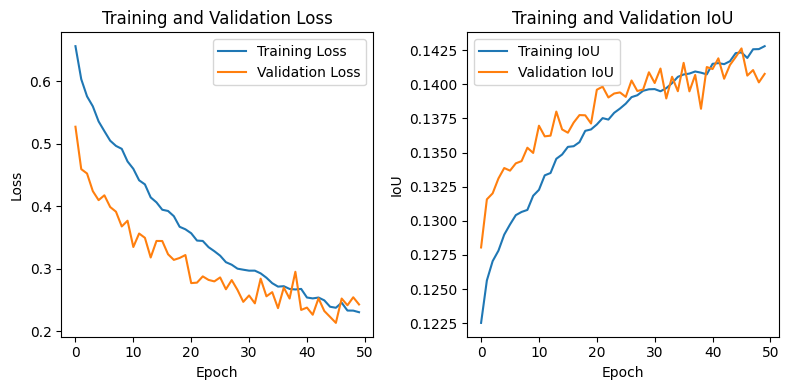

In [139]:
# Training loop
train_losses = []
val_losses = []
train_iou = []
val_iou = []
bestScore = float('inf')

for epoch in range(num_epochs):
    train_loss, train_avg_iou = train(model, train_loader, dice_loss, optimizer, device, iou_metric)
    val_loss, val_avg_iou = validate(model, val_loader, dice_loss, device, iou_metric)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_iou.append(train_avg_iou)
    val_iou.append(val_avg_iou)

    clear_output(wait=True)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train IoU: {train_avg_iou:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation IoU: {val_avg_iou:.4f}')

    # Plotting Loss and IoU
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_iou, label='Training IoU')
    plt.plot(val_iou, label='Validation IoU')
    plt.title('Training and Validation IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Save best model
    if val_loss < bestScore:
        bestScore = val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), checkpoints_path)


In [140]:
print(1 - bestScore)

0.7863262027274561


prediction


In [158]:
# Inference
REAL_img_path = "/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 6/masks/image_part_001.png"
img_path = "/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 6/images/image_part_001.jpg"



In [159]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
from patchify import patchify, unpatchify
import matplotlib.pyplot as plt

# Initialize the model
model = ImageSegmentation(3)
model.load_state_dict(torch.load(checkpoints_path, map_location=device))
model.to(device)
model.eval()

# Load the image
img = Image.open(img_path)

# Ensure the image size is compatible with the patch size
patch_size = 256
SIZE_X = (img.size[0] // patch_size) * patch_size
SIZE_Y = (img.size[1] // patch_size) * patch_size
large_img = img.crop((0, 0, SIZE_X, SIZE_Y))
large_img = np.array(large_img)

# Patchify the image
patches_img = patchify(large_img, (patch_size, patch_size, 3), step=patch_size)
patches_img = patches_img[:, :, 0, :, :, :]

# Prepare patched predictions
patched_prediction = []
for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
        single_patch_img = patches_img[i, j, :, :, :]
        single_patch_tensor = torch.from_numpy(single_patch_img).float()
        single_patch_tensor /= 255.0
        single_patch_tensor = single_patch_tensor.permute(2, 0, 1).unsqueeze(0).to(device)

        # Normalize the tensor
        mean = torch.tensor([0.5, 0.5, 0.5]).to(device)
        std = torch.tensor([0.5, 0.5, 0.5]).to(device)
        single_patch_tensor = (single_patch_tensor - mean[None, :, None, None]) / std[None, :, None, None]

        with torch.no_grad():
            pred = model(single_patch_tensor)
        pred = torch.argmax(pred, dim=1).squeeze(0).cpu().numpy()
        patched_prediction.append(pred)

# Reshape the patched prediction array
patched_prediction = np.array(patched_prediction)
patched_prediction = np.reshape(patched_prediction, (patches_img.shape[0], patches_img.shape[1], patch_size, patch_size))

# Unpatchify the prediction
unpatched_prediction = unpatchify(patched_prediction, (SIZE_Y, SIZE_X))


In [160]:

# Function to convert label to RGB
def label_to_rgb(predicted_image):
    Building = np.array([60, 16, 152])
    Land = np.array([132, 41, 246])
    Road = np.array([110, 193, 228])
    Vegetation = np.array([254, 221, 58])
    Water = np.array([226, 169, 41])
    Unlabeled = np.array([155, 155, 155])

    segmented_img = np.empty((predicted_image.shape[0], predicted_image.shape[1], 3))
    segmented_img[(predicted_image == 0)] = Building
    segmented_img[(predicted_image == 1)] = Land
    segmented_img[(predicted_image == 2)] = Road
    segmented_img[(predicted_image == 3)] = Vegetation
    segmented_img[(predicted_image == 4)] = Water
    segmented_img[(predicted_image == 5)] = Unlabeled

    segmented_img = segmented_img.astype(np.uint8)
    return segmented_img


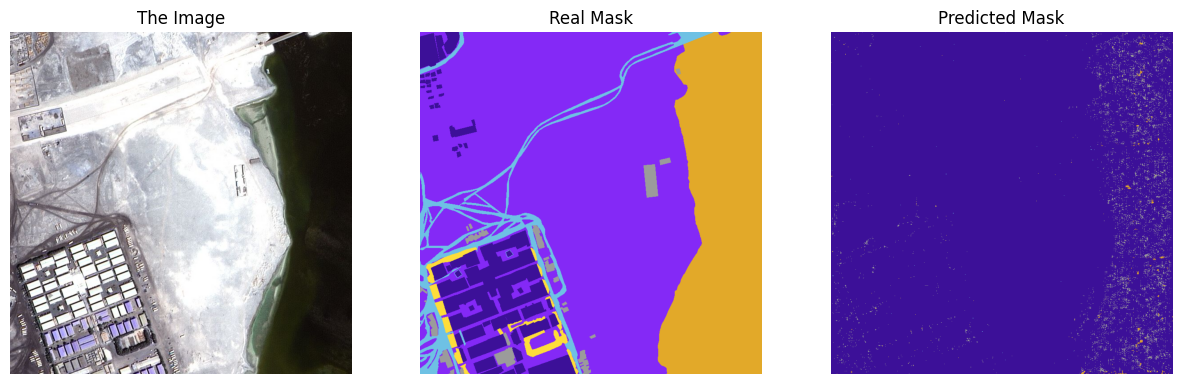

In [161]:

# Convert the prediction to RGB
prediction = label_to_rgb(unpatched_prediction)

# Load the original and real mask images
G_img = Image.open(img_path)
REAL_img = Image.open(REAL_img_path)

# Ensure the images are the correct size
G_img = G_img.crop((0, 0, SIZE_X, SIZE_Y))
G_img = np.array(G_img)
REAL_img = REAL_img.crop((0, 0, SIZE_X, SIZE_Y))
REAL_img = np.array(REAL_img)

# Plot the images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(G_img)
plt.title("The Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(REAL_img)
plt.title("Real Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(prediction)
plt.title("Predicted Mask")
plt.axis('off')

plt.show()


# Model Initialization & Configuration -deactived


In [145]:
"""import torch.optim as optim


ldl = len(train_loader)

num_epochs = 50

optimizer = optim.Adam(model.parameters(), lr=0.001)


if(torch.cuda.is_available()):
    device = torch.device('cuda')
elif(torch.backends.mps.is_available()):
    device = torch.device('mps')
else:
    device = torch.device('cpu')

model.to(device)"""

"import torch.optim as optim\n\n\nldl = len(train_loader)\n\nnum_epochs = 50\n\noptimizer = optim.Adam(model.parameters(), lr=0.001)\n\n\nif(torch.cuda.is_available()):\n    device = torch.device('cuda')\nelif(torch.backends.mps.is_available()):\n    device = torch.device('mps')\nelse:\n    device = torch.device('cpu')\n\nmodel.to(device)"

# Accuracy Function -deactived


In [146]:
"""import torch

def compute_accuracy(testDataLoader,loss_fn,model,device):

    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn.calculate_average_dice_loss(outputs, labels)
            total_loss += loss.item()

    return total_loss / len(val_loader)"""

'import torch\n\ndef compute_accuracy(testDataLoader,loss_fn,model,device):\n\n    model.eval()  \n    total_loss = 0.0\n    with torch.no_grad():\n        for inputs, labels in val_loader:\n            inputs, labels = inputs.to(device), labels.to(device)\n            outputs = model(inputs)\n            loss = loss_fn.calculate_average_dice_loss(outputs, labels)\n            total_loss += loss.item()\n\n    return total_loss / len(val_loader)'

# Main Training Loop -deactived


In [147]:
"""from tqdm import tqdm

train_losses = []
cross_losses = []
bestScore=1
for epoch in range(num_epochs):
    train_loss = train(model, train_loader,dice_loss, optimizer, device, ldl, ldl*4)
    Current_loss = compute_accuracy(val_loader,dice_loss, model,device)
    print(Current_loss)
    train_losses.append(train_loss)
    cross_losses.append(Current_loss)

    clear_output(wait=True)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}')
    print(f'Cross Acc: {Current_loss:.4f}')
    #scheduler.step()

    # initialize 3 subplots to plot the loss curve, learning rate curve and accuracy curve
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(cross_losses, label='Validation Loss')
    plt.title('Training Loss and Validation Loss')
    plt.legend()
    plt.show(block=False)


    if Current_loss < bestScore:
        bestScore = Current_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')"""

"from tqdm import tqdm\n\ntrain_losses = []\ncross_losses = []\nbestScore=1\nfor epoch in range(num_epochs):\n    train_loss = train(model, train_loader,dice_loss, optimizer, device, ldl, ldl*4)\n    Current_loss = compute_accuracy(val_loader,dice_loss, model,device)\n    print(Current_loss)\n    train_losses.append(train_loss)\n    cross_losses.append(Current_loss)\n\n    clear_output(wait=True)\n    \n    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}')\n    print(f'Cross Acc: {Current_loss:.4f}')\n    #scheduler.step()\n\n    # initialize 3 subplots to plot the loss curve, learning rate curve and accuracy curve\n    plt.figure(figsize=(10, 5))\n    plt.plot(train_losses, label='Training Loss')\n    plt.plot(cross_losses, label='Validation Loss')\n    plt.title('Training Loss and Validation Loss')\n    plt.legend()\n    plt.show(block=False)\n    \n    \n    if Current_loss < bestScore:\n        bestScore = Current_loss\n        best_epoch = epoch\n        torch.s

In [148]:
#print(1-bestScore)

# Predictions -deactived

In [149]:
#REAL_img_path = "/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 6/masks/image_part_001.png"
#img_path = "/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 6/images/image_part_001.jpg"

In [150]:
"""import torch
from torchvision import transforms
from PIL import Image
import numpy as np
from patchify import patchify, unpatchify
import matplotlib.pyplot as plt

model = ImageSegmentation(3)
model.load_state_dict(torch.load(checkpoints_path, map_location=device))
model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

img = Image.open(img_path)

patch_size = 256
SIZE_X = (img.size[0] // patch_size) * patch_size
SIZE_Y = (img.size[1] // patch_size) * patch_size
large_img = img.crop((0, 0, SIZE_X, SIZE_Y))
large_img = np.array(large_img)

patches_img = patchify(large_img, (patch_size, patch_size, 3), step=patch_size)
patches_img = patches_img[:, :, 0, :, :, :]

patched_prediction = []
for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
        single_patch_img = patches_img[i, j, :, :, :]
        single_patch_tensor = torch.from_numpy(single_patch_img).float()
        single_patch_tensor /= 255.0
        single_patch_tensor = single_patch_tensor.permute(2, 0, 1)

        single_patch_tensor = transform(single_patch_tensor).unsqueeze(0)

        with torch.no_grad():
            pred = model(single_patch_tensor)
        pred = torch.argmax(pred, dim=1).squeeze(0).cpu().numpy()
        patched_prediction.append(pred)

patched_prediction = np.array(patched_prediction)
patched_prediction = np.reshape(patched_prediction, [patches_img.shape[0], patches_img.shape[1], patch_size, patch_size])

unpatched_prediction = unpatchify(patched_prediction, (SIZE_Y, SIZE_X))"""


'import torch\nfrom torchvision import transforms\nfrom PIL import Image\nimport numpy as np\nfrom patchify import patchify, unpatchify\nimport matplotlib.pyplot as plt\n\nmodel = ImageSegmentation(3)\nmodel.load_state_dict(torch.load(checkpoints_path, map_location=device))\nmodel.to(device)\nmodel.eval()\n\ntransform = transforms.Compose([\n    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),\n])\n\nimg = Image.open(img_path)\n\npatch_size = 256\nSIZE_X = (img.size[0] // patch_size) * patch_size\nSIZE_Y = (img.size[1] // patch_size) * patch_size\nlarge_img = img.crop((0, 0, SIZE_X, SIZE_Y))\nlarge_img = np.array(large_img)\n\npatches_img = patchify(large_img, (patch_size, patch_size, 3), step=patch_size)\npatches_img = patches_img[:, :, 0, :, :, :]\n\npatched_prediction = []\nfor i in range(patches_img.shape[0]):\n    for j in range(patches_img.shape[1]):\n        single_patch_img = patches_img[i, j, :, :, :]\n        single_patch_tensor = torch.from_numpy(single_patch_img).flo

In [151]:
"""def label_to_rgb(predicted_image):

    Building = '#3C1098'.lstrip('#')
    Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

    Land = '#8429F6'.lstrip('#')
    Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

    Road = '#6EC1E4'.lstrip('#')
    Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

    Vegetation =  'FEDD3A'.lstrip('#')
    Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

    Water = 'E2A929'.lstrip('#')
    Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

    Unlabeled = '#9B9B9B'.lstrip('#')
    Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155



    segmented_img = np.empty((predicted_image.shape[0], predicted_image.shape[1], 3))

    segmented_img[(predicted_image == 0)] = Building
    segmented_img[(predicted_image == 1)] = Land
    segmented_img[(predicted_image == 2)] = Road
    segmented_img[(predicted_image == 3)] = Vegetation
    segmented_img[(predicted_image == 4)] = Water
    segmented_img[(predicted_image == 5)] = Unlabeled

    segmented_img = segmented_img.astype(np.uint8)
    return(segmented_img)"""

"def label_to_rgb(predicted_image):\n    \n    Building = '#3C1098'.lstrip('#')\n    Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152\n    \n    Land = '#8429F6'.lstrip('#')\n    Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246\n    \n    Road = '#6EC1E4'.lstrip('#') \n    Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228\n    \n    Vegetation =  'FEDD3A'.lstrip('#') \n    Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58\n    \n    Water = 'E2A929'.lstrip('#') \n    Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41\n    \n    Unlabeled = '#9B9B9B'.lstrip('#') \n    Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155\n    \n    \n    \n    segmented_img = np.empty((predicted_image.shape[0], predicted_image.shape[1], 3))\n    \n    segmented_img[(predicted_image == 0)] = Building\n    seg

In [152]:
"""from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


# Load the images
G_img = Image.open(img_path)
REAL_img = Image.open(REAL_img_path)


# Define patch size and adjust the size of G_img
patch_size = 256
SIZE_X = (G_img.size[0] // patch_size) * patch_size
SIZE_Y = (G_img.size[1] // patch_size) * patch_size
G_img = G_img.crop((0, 0, SIZE_X, SIZE_Y))
G_img = np.array(G_img)


patch_size = 256
SIZE_X = (REAL_img.size[0] // patch_size) * patch_size
SIZE_Y = (REAL_img.size[1] // patch_size) * patch_size
REAL_img = REAL_img.crop((0, 0, SIZE_X, SIZE_Y))
REAL_img = np.array(REAL_img)
REAL_img = np.array(REAL_img)


prediction = label_to_rgb(unpatched_prediction)

# Plot the images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(G_img)
plt.title("The Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(REAL_img)
plt.title("Real Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(prediction)
plt.title("Predicted Mask")
plt.axis('off')

plt.show()"""


'from PIL import Image\nimport numpy as np\nimport matplotlib.pyplot as plt\n\n\n# Load the images\nG_img = Image.open(img_path)\nREAL_img = Image.open(REAL_img_path)\n\n\n# Define patch size and adjust the size of G_img\npatch_size = 256\nSIZE_X = (G_img.size[0] // patch_size) * patch_size\nSIZE_Y = (G_img.size[1] // patch_size) * patch_size\nG_img = G_img.crop((0, 0, SIZE_X, SIZE_Y))\nG_img = np.array(G_img)\n\n\npatch_size = 256\nSIZE_X = (REAL_img.size[0] // patch_size) * patch_size\nSIZE_Y = (REAL_img.size[1] // patch_size) * patch_size\nREAL_img = REAL_img.crop((0, 0, SIZE_X, SIZE_Y))\nREAL_img = np.array(REAL_img)\nREAL_img = np.array(REAL_img)\n\n\nprediction = label_to_rgb(unpatched_prediction)\n\n# Plot the images\nplt.figure(figsize=(15, 5))\nplt.subplot(1, 3, 1)\nplt.imshow(G_img)\nplt.title("The Image")\nplt.axis(\'off\')\n\nplt.subplot(1, 3, 2)\nplt.imshow(REAL_img)\nplt.title("Real Mask")\nplt.axis(\'off\')\n\nplt.subplot(1, 3, 3)\nplt.imshow(prediction)\nplt.title("Pred

# Post Processing

In [162]:
gray = cv2.cvtColor(prediction, cv2.COLOR_RGB2GRAY)

# Detect edges using Sobel filter
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)  # Horizontal edges
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)  # Vertical edges

# Absolute and convert to 8-bit
abs_sobelx = cv2.convertScaleAbs(sobelx)
abs_sobely = cv2.convertScaleAbs(sobely)
edges = cv2.bitwise_or(abs_sobelx, abs_sobely)


_, binary = cv2.threshold(edges, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Inpaint the original image
post_processed = cv2.inpaint(prediction, binary.astype(np.uint8), 5, cv2.INPAINT_TELEA)



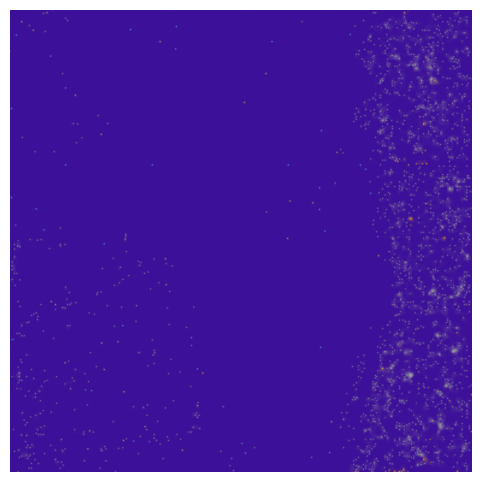

In [163]:
# Plot the result
plt.figure(figsize=(10, 6))
plt.imshow(post_processed)
plt.axis('off')
plt.show()

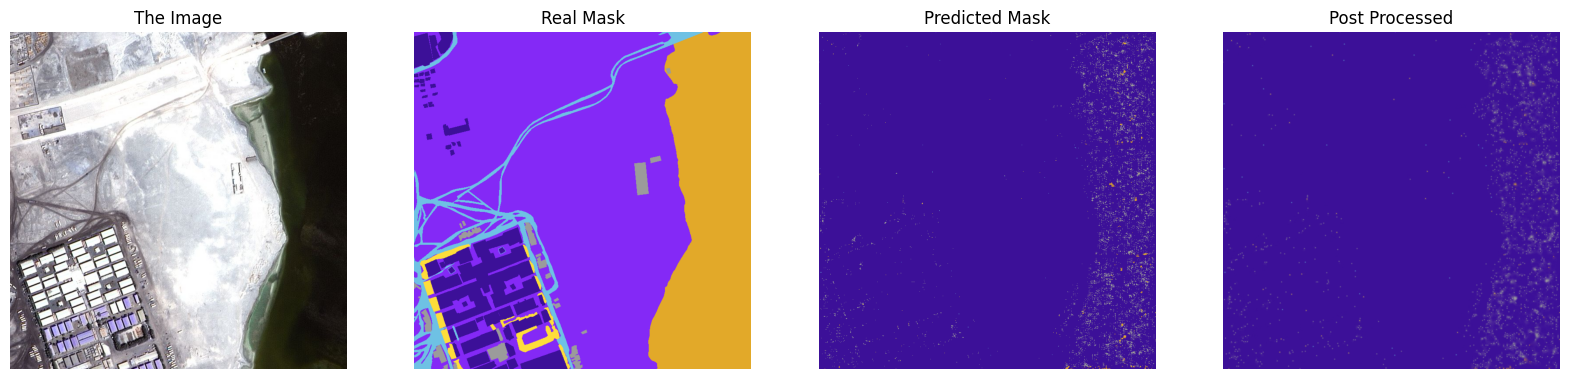

In [164]:
# Plotting the images
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.imshow(G_img)
plt.title("The Image")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(REAL_img)
plt.title("Real Mask")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(prediction)
plt.title("Predicted Mask")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(post_processed)
plt.title("Post Processed")
plt.axis('off')

plt.show()

Post Processing testing¶



In [156]:

Real = rgb_to_2D_label(REAL_img)
post = rgb_to_2D_label(post_processed)

Real = to_categorical(Real)
post = to_categorical(post)

# Calculate Dice loss for each channel
dice_losses = []
num_channels = Real.shape[-1]  # Define num_channels based on the last dimension of Real


for channel in range(num_channels):
    input_channel = torch.tensor(post[channel]).unsqueeze(0)
    target_channel = torch.tensor(Real[channel]).unsqueeze(0)

    loss_channel = dice_loss(input_channel, target_channel)
    dice_losses.append(loss_channel)

average_dice_loss = np.mean(dice_losses)

# Calculate average Dice score
average_dice_score = 1 - average_dice_loss
print(f'Average Dice Score of post processed maks: {average_dice_score}')

Average Dice Score of post processed maks: 0.6801562309265137


In [157]:
pred = rgb_to_2D_label(prediction)
pred = to_categorical(pred)


# Calculate Dice loss for each channel
dice_losses = []
for channel in range(num_channels):
    input_channel = torch.tensor(pred[channel]).unsqueeze(0)
    target_channel = torch.tensor(Real[channel]).unsqueeze(0)

    loss_channel = dice_loss(input_channel, target_channel)
    dice_losses.append(loss_channel)

average_dice_loss = np.mean(dice_losses)


# Calculate average Dice score
average_dice_score = 1 - average_dice_loss
print(f'Average Dice Score of predicted mask: {average_dice_score}')

Average Dice Score of predicted mask: 0.6801562309265137


The Post-Processing is good as it removes the lines effect without effecting the Dice Coeff very much (3% on average)¶
